In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [2]:
from phase_scan import PhaseScan

In [3]:
decimation_data_comercial = pd.read_csv("Decimation.csv")
decimation_data_mmi = pd.read_csv("Decimation2.csv")

# DC Values

## Comercial Coupler

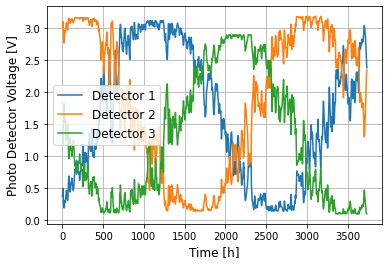

In [4]:
time = np.arange(len(decimation_data_comercial["DC CH1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data_comercial[f"DC CH{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

## MMI Coupler

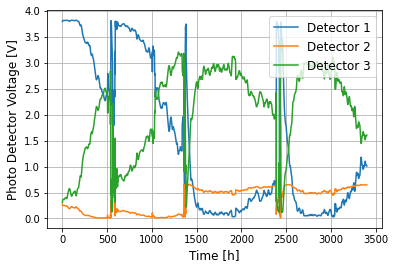

In [5]:
time = np.arange(len(decimation_data_mmi["DC CH1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data_mmi[f"DC CH{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

# RMS Values

## Comercial Coupler

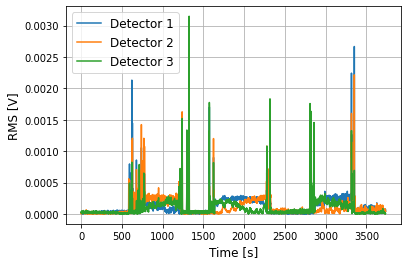

In [6]:
time = np.arange(len(decimation_data_comercial["RMS CH1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data_comercial[f"RMS CH{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

## MMI Coupler

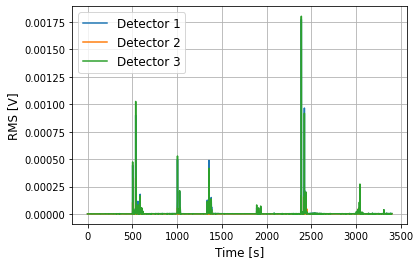

In [7]:
time = np.arange(len(decimation_data_mmi["RMS CH1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data_mmi[f"RMS CH{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

# Response Phases

## Comercial Coupler

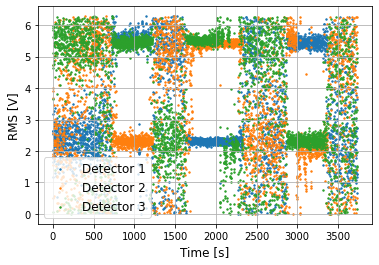

In [8]:
time = np.arange(len(decimation_data_comercial["Response Phase CH1"]))
for channel in range(1, 4):
    data = decimation_data_comercial[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_comercial[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    plt.scatter(time, data, label=f"Detector {channel}", s=2)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

In [9]:
response_phase_comercial = []
for channel in range(1, 4):
    data = decimation_data_comercial[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_comercial[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    response_phase_comercial.append(np.mean(data[750:1000]))
response_phase_comercial = np.array(response_phase_comercial)
response_phase_comercial

array([5.41991185, 2.3311673 , 5.26887553])

In [10]:
response_phase_comercial[1] += np.pi
response_phase_comercial

array([5.41991185, 5.47275996, 5.26887553])

## MMI Coupler

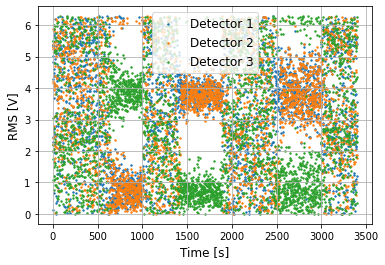

In [11]:
time = np.arange(len(decimation_data_mmi["Response Phase CH1"]))
for channel in range(1, 4):
    data = decimation_data_mmi[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_mmi[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    plt.scatter(time, data, label=f"Detector {channel}", s=2)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

In [12]:
response_phase_mmi = []
for channel in range(1, 4):
    data = decimation_data_mmi[f"Response Phase CH{channel}"].to_numpy()
    data[decimation_data_mmi[f"Response Phase CH{channel}"] < 0] += 2 * np.pi
    response_phase_mmi.append(np.mean(data[1500:1700]))
response_phase_mmi = np.array(response_phase_mmi)
response_phase_mmi

array([3.85469237, 3.79878346, 0.72470109])

In [13]:
response_phase_mmi = np.array(response_phase_mmi)
response_phase_mmi[2] += np.pi
response_phase_mmi

array([3.85469237, 3.79878346, 3.86629375])

# Interferometric Phase

In [14]:
def detector_1(intensity, detector):
    phi = np.arccos(intensity[0])
    return lambda x: (np.cos(phi - x) - intensity[detector]) ** 2

def detector_2(intensity, detector):
    phi = 2 * np.pi - np.arccos(intensity[0])
    return lambda x: (np.cos(phi - x) - intensity[detector]) ** 2

def detector_1_df(intensity, detector):
    phi = np.arccos(intensity[0])
    return lambda x: 2 * (np.cos(phi - x) - intensity[detector]) * np.sin(phi - x)

def detector_2_df(intensity, detector):
    phi = 2 * np.pi - np.arccos(intensity[0])
    return lambda x: 2 * (np.cos(phi - x) - intensity[detector]) * np.sin(phi - x)


## Comercial Coupler

In [15]:
min_values = []
max_values = []
t = 0
results_detector_1 = []
phases_comercial_coupler = []
results_detector_2 = []
last_time = 0

data = np.array([decimation_data_comercial["DC CH1"], decimation_data_comercial["DC CH2"], decimation_data_comercial["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

for i in range(len(data)):
    signal = np.array([decimation_data_comercial["DC CH1"][i], decimation_data_comercial["DC CH2"][i], decimation_data_comercial["DC CH3"][i]])
    signal = 2 * (signal - phase_scan.min_intensities) / (phase_scan.max_intensities - phase_scan.min_intensities) - 1
    res_1 = minimize(detector_1(signal, 1), x0=np.array([2.154]), jac=detector_1_df(signal, 1)).x[0]
    res_2 = minimize(detector_2(signal, 1), x0=np.array([2.154]), jac=detector_2_df(signal, 1)).x[0]
    if np.abs(res_1 - 2.154) < np.abs(res_2 - 2.154):
        results_detector_1.append(res_1)
        phases_comercial_coupler.append(np.arccos(signal[0]))
        res_1 = minimize(detector_1(signal, 2), x0=np.array([4.223]), jac=detector_1_df(signal, 2)).x[0]
        results_detector_2.append(res_1)
    else:
        results_detector_1.append(res_2)
        phases_comercial_coupler.append(2 * np.pi - np.arccos(signal[0]))
        res_2 = minimize(detector_2(signal, 2), x0=np.array([4.223]), jac=detector_2_df(signal, 2)).x[0]
        results_detector_2.append(res_2)
    t += 1

In [16]:
output_phase_1_comercial_coupler = np.array(results_detector_1)
output_phase_2_comercial_coupler = np.array(results_detector_2)

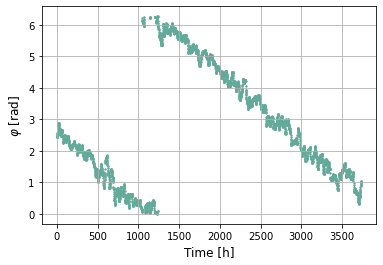

In [17]:
plt.scatter(range(len(phases_comercial_coupler)), phases_comercial_coupler, label="Interferometrio Phase", s=2, color="#64AA9A")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel(r"$\varphi$ [rad]", fontsize=12)
plt.grid()
plt.show()

## MMI Coupler

In [18]:
min_values = []
max_values = []
t = 0
results_detector_1 = []
phases_mmi_coupler = []
results_detector_2 = []
last_time = 0

data = np.array([decimation_data_mmi["DC CH1"], decimation_data_mmi["DC CH2"], decimation_data_mmi["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

for i in range(len(data)):
    signal = np.array([decimation_data_mmi["DC CH1"][i], decimation_data_mmi["DC CH2"][i], decimation_data_mmi["DC CH3"][i]])
    signal = 2 * (signal - phase_scan.min_intensities) / (phase_scan.max_intensities - phase_scan.min_intensities) - 1
    res_1 = minimize(detector_1(signal, 1), x0=np.array([1.863]), jac=detector_1_df(signal, 1)).x[0]
    res_2 = minimize(detector_2(signal, 1), x0=np.array([1.863]), jac=detector_2_df(signal, 1)).x[0]
    if np.abs(res_1 - 1.863) < np.abs(res_2 - 1.863):
        results_detector_1.append(res_1)
        phases_mmi_coupler.append(np.arccos(signal[0]))
        res_1 = minimize(detector_1(signal, 2), x0=np.array([3.769]), jac=detector_1_df(signal, 2)).x[0]
        results_detector_2.append(res_1)
    else:
        results_detector_1.append(res_2)
        phases_mmi_coupler.append(2 * np.pi - np.arccos(signal[0]))
        res_2 = minimize(detector_2(signal, 2), x0=np.array([3.769]), jac=detector_2_df(signal, 2)).x[0]
        results_detector_2.append(res_2)
    t += 1

In [19]:
output_phase_1_mmi_coupler = np.array(results_detector_1)
output_phase_2_mmi_coupler = np.array(results_detector_2)

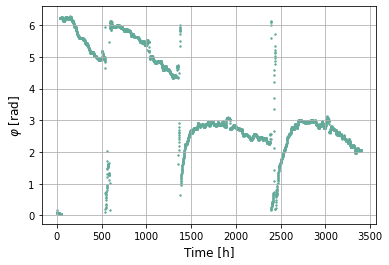

In [20]:
plt.scatter(range(len(phases_mmi_coupler)), phases_mmi_coupler, label="Interferometrio Phase", s=2, color="#64AA9A")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel(r"$\varphi$ [rad]", fontsize=12)
plt.grid()
plt.show()

# PTI Signal

In [21]:
def calculate_pti_signal(root_mean_square: np.array, lock_in_phase: np.array, output_phases: np.array, phases: np.array,
                         phase_scan: PhaseScan, response_phases: np.array) -> np.array:
    pti_signal = np.zeros(shape=phase_scan.scaled_signals.shape).T
    weight = np.zeros(shape=phase_scan.scaled_signals.shape).T
    for channel in range(3):
        sign = np.sin(phases - output_phases[channel]) > 0
        reponse_phase = response_phases[channel]
        demoudalted_signal = root_mean_square[channel] * np.cos(lock_in_phase[channel] - reponse_phase)
        pti_signal += demoudalted_signal * sign
        weight += (PhaseScan.max_intensities[channel] - PhaseScan.min_intensities[channel]) / 2 * np.abs(np.sin(phases - output_phases[channel]))
    pti = np.sum(-pti_signal, axis=0) / np.sum(weight, axis=0)
    scaling = sum([PhaseScan.max_intensities[channel] - PhaseScan.min_intensities[channel] / 2 for channel in range(3)])
    return pti * 1e6

## Comercial Coupler

In [22]:
data = np.array([decimation_data_comercial["DC CH1"], decimation_data_comercial["DC CH2"], decimation_data_comercial["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

pti_comercial = calculate_pti_signal(root_mean_square=np.array([decimation_data_comercial[f"RMS CH{i}"] for i in range(1, 4)]),
                            lock_in_phase=np.array([decimation_data_comercial[f"Response Phase CH{i}"] for i in range(1, 4)]),
                            phases=phases_comercial_coupler, phase_scan=phase_scan, response_phases=np.array(response_phase_comercial),
                            output_phases=np.array([0, 2.154, 4.223]))
pti_comercial = pti_comercial / np.sum(data, axis=1)
pti_mean_comercial = np.mean(np.array(pti_comercial).reshape(-1, 8), axis=1)
time_mean_comercial = np.arange(pti_mean_comercial.size)
time_mean_comercial *= 8

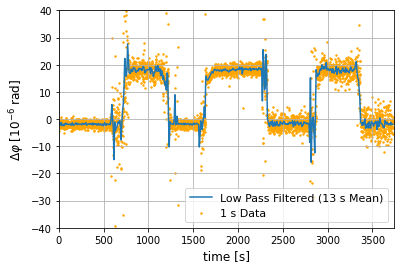

In [23]:
plt.plot(time_mean_comercial, -pti_mean_comercial, label="Low Pass Filtered (13 s Mean)")
plt.scatter(range(len(pti_comercial)), -pti_comercial, color="orange", s=2, label="1 s Data")
plt.grid()
plt.axis([0, len(pti_comercial), -40, 40])
plt.xlabel("time [s]", fontsize=12)
plt.ylabel(r"$\Delta\varphi$ [$10^{-6}$ rad]", fontsize=12)
plt.legend(fontsize=11)
plt.show()

In [24]:
data = np.array([decimation_data_mmi["DC CH1"], decimation_data_mmi["DC CH2"], decimation_data_mmi["DC CH3"]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
phase_scan.scale_data()

pti_mmi = calculate_pti_signal(root_mean_square=np.array([decimation_data_mmi[f"RMS CH{i}"] for i in range(1, 4)]),
                                     lock_in_phase=np.array([decimation_data_mmi[f"Response Phase CH{i}"] for i in range(1, 4)]),
                                     phases=phases_mmi_coupler, phase_scan=phase_scan, response_phases=np.array(response_phase_mmi),
                                     output_phases=np.array([0, 1.863, 3.769]))
pti_mmi = pti_mmi / np.sum(data, axis=1)
pti_mean_mmi = np.mean(np.array(pti_mmi).reshape(-1, 7), axis=1)
time_mean = np.arange(pti_mean_mmi.size)
time_mean *= 7

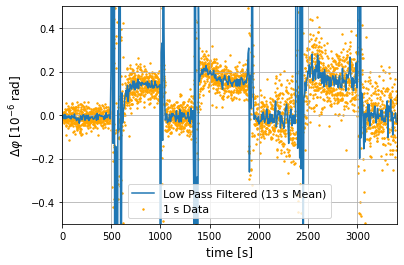

In [25]:
plt.plot(time_mean, -pti_mean_mmi, label="Low Pass Filtered (13 s Mean)")
plt.scatter(range(len(pti_mmi)), -pti_mmi, color="orange", s=2, label="1 s Data")
plt.grid()
plt.axis([0, len(pti_mmi), -0.5, 0.5])
plt.xlabel("time [s]", fontsize=12)
plt.ylabel(r"$\Delta\varphi$ [$10^{-6}$ rad]", fontsize=12)
plt.legend(fontsize=11)
plt.show()

# Output Phases

## Comercial Coupler

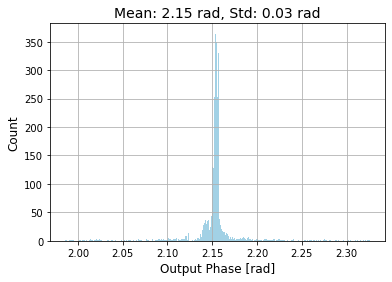

In [26]:
plt.hist(output_phase_1_comercial_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {np.round(np.mean(output_phase_1_comercial_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_1_comercial_coupler), 2)} rad", fontsize=14)
plt.grid()
plt.show()

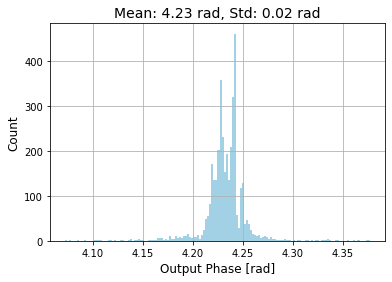

In [27]:
plt.hist(output_phase_2_comercial_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid()
plt.title(f"Mean: {np.round(np.mean(output_phase_2_comercial_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_2_comercial_coupler), 2)} rad", fontsize=14)
plt.show()

## MMI Coupler

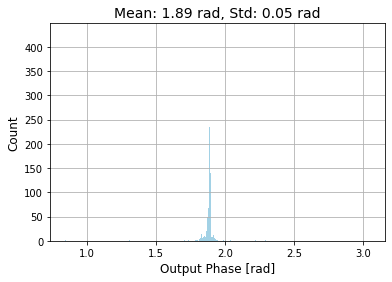

In [28]:
plt.hist(output_phase_1_mmi_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {np.round(np.mean(output_phase_1_mmi_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_1_mmi_coupler), 2)} rad", fontsize=14)
plt.grid()
plt.show()

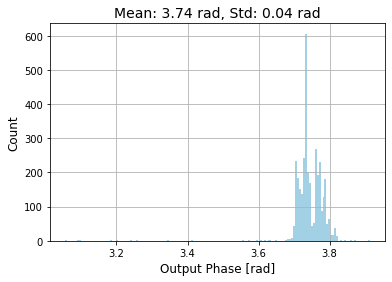

In [29]:
plt.hist(output_phase_2_mmi_coupler, bins="auto", color="#a2d1e5")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {np.round(np.mean(output_phase_2_mmi_coupler), 2)} rad,"
          f" Std: {np.round(np.std(output_phase_2_mmi_coupler), 2)} rad", fontsize=14)
plt.grid()
plt.show()